In [1]:
pip install dadaptation

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for dadaptation: filename=dadaptation-3.2-py3-none-any.whl size=23208 sha256=df1f33e547fea793defaa52f049dcddae50bb8f275f57159aae09ef3ab8072ed
  Stored in directory: /root/.cache/pip/wheels/d0/03/6d/feba04df15ef39d9ac4e3504058ac2a88fb2ef9183ba92b111
Successfully built dadaptation


In [2]:

from dadaptation.dadapt_adagrad import DAdaptAdaGrad
from dadaptation.dadapt_adam import DAdaptAdam
from dadaptation.dadapt_sgd import DAdaptSGD
from dadaptation.dadapt_adan import DAdaptAdan
from dadaptation.dadapt_lion import DAdaptLion


100%|██████████| 170498071/170498071 [00:13<00:00, 12214949.36it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Epoch [1/25], Loss: 1.3103, Accuracy: 52.06%
Epoch [2/25], Loss: 0.8794, Accuracy: 68.91%
Epoch [3/25], Loss: 0.7122, Accuracy: 75.19%
Epoch [4/25], Loss: 0.5984, Accuracy: 79.23%
Epoch [5/25], Loss: 0.5202, Accuracy: 82.10%
Epoch [6/25], Loss: 0.4665, Accuracy: 84.00%
Epoch [7/25], Loss: 0.4229, Accuracy: 85.38%
Epoch [8/25], Loss: 0.3860, Accuracy: 86.71%
Epoch [9/25], Loss: 0.3519, Accuracy: 87.90%
Epoch [10/25], Loss: 0.3257, Accuracy: 88.85%
Epoch [11/25], Loss: 0.3017, Accuracy: 89.56%
Epoch [12/25], Loss: 0.2812, Accuracy: 90.22%
Epoch [13/25], Loss: 0.2586, Accuracy: 90.86%
Epoch [14/25], Loss: 0.2444, Accuracy: 91.57%
Epoch [15/25], Loss: 0.2267, Accuracy: 92.07%
Epoch [16/25], Loss: 0.2123, Accuracy: 92.65%
Epoch [17/25], Loss: 0.1951, Accuracy: 93.35%
Epoch [18/25], Loss: 0.1866, Accuracy: 93.47%
Epoch [19/25], Loss: 0.1736, Accuracy: 94.00%
Epoch [20/25], Loss: 0.1635, Accuracy: 94.32%
Epoch [21/25], Loss: 0.1509, Accuracy:

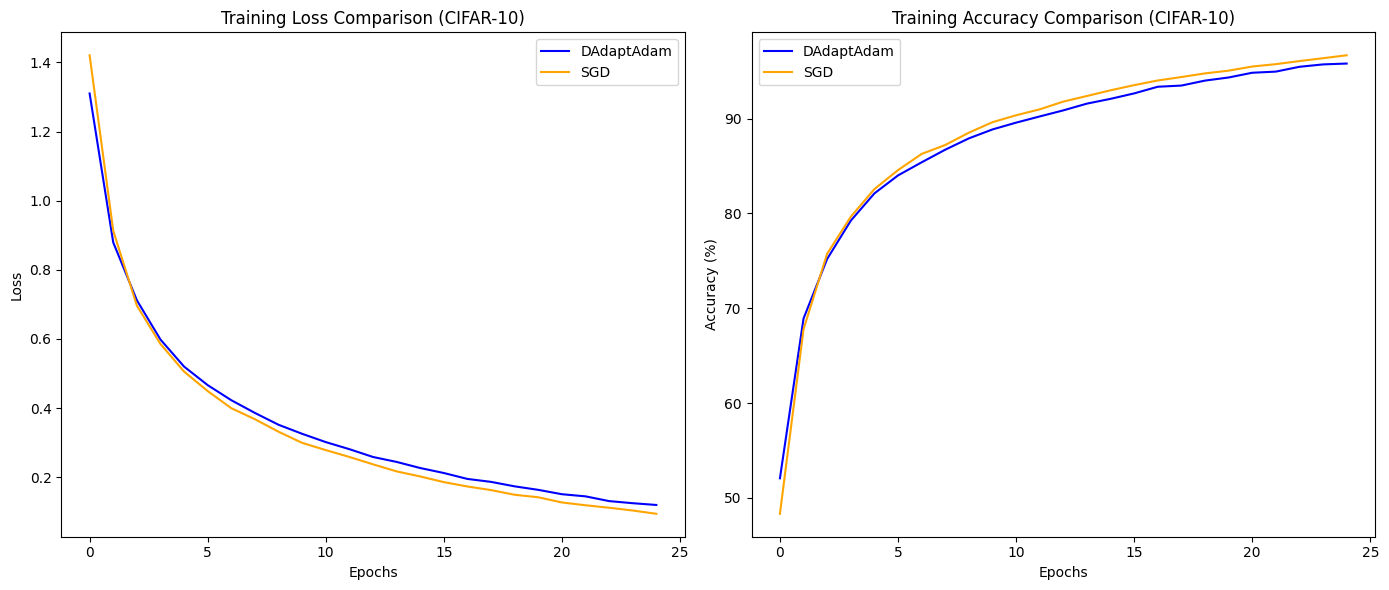

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms
import matplotlib.pyplot as plt


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Define the Wide Residual Block
class WideResNetBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride, widen_factor):
        super(WideResNetBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels * widen_factor, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels * widen_factor)
        self.conv2 = nn.Conv2d(out_channels * widen_factor, out_channels * widen_factor, kernel_size=3, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels * widen_factor)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels * widen_factor:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels * widen_factor, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels * widen_factor)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out

# Define the Wide Residual Network (WRN)
class WideResNet(nn.Module):
    def __init__(self, depth, widen_factor, num_classes):
        super(WideResNet, self).__init__()
        self.in_channels = 16
        self.conv1 = nn.Conv2d(3, self.in_channels, kernel_size=3, padding=1, bias=False)  # 3 channels for CIFAR-10
        self.bn1 = nn.BatchNorm2d(self.in_channels)

        n = (depth - 4) // 6
        self.layer1 = self._make_layer(WideResNetBlock, 16, n, stride=1, widen_factor=widen_factor)
        self.layer2 = self._make_layer(WideResNetBlock, 32, n, stride=2, widen_factor=widen_factor)
        self.layer3 = self._make_layer(WideResNetBlock, 64, n, stride=2, widen_factor=widen_factor)

        self.fc = nn.Linear(64 * widen_factor, num_classes)

    def _make_layer(self, block, out_channels, n, stride, widen_factor):
        layers = []
        layers.append(block(self.in_channels, out_channels, stride, widen_factor))
        self.in_channels = out_channels * widen_factor
        for _ in range(1, n):
            layers.append(block(self.in_channels, out_channels, 1, widen_factor))
        return nn.Sequential(*layers)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = F.adaptive_avg_pool2d(x, 1)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

# Prepare the CIFAR-10 dataset and DataLoader
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
])
train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)

# Initialize model, criterion, and optimizers
model = WideResNet(depth=16, widen_factor=8, num_classes=10).to(device)  # WRN-16-8 for CIFAR-10
criterion = nn.CrossEntropyLoss()
optimizer_dadapt = DAdaptAdam(model.parameters())  # Ensure DAdaptAdam is defined or imported
optimizer_sgd = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

# Define a training function
def train(model, optimizer, epochs, train_loader, criterion):
    model.train()
    train_losses = []
    train_accs = []

    for epoch in range(epochs):
        total_loss = 0
        correct = 0
        total = 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)  # Move data to GPU
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        avg_loss = total_loss / len(train_loader)
        accuracy = 100 * correct / total
        train_losses.append(avg_loss)
        train_accs.append(accuracy)

        print(f'Epoch [{epoch+1}/{epochs}], Loss: {avg_loss:.4f}, Accuracy: {accuracy:.2f}%')

    return train_losses, train_accs

# Train with DAdaptAdam
epochs = 50
train_losses_dadapt, train_accs_dadapt = train(model, optimizer_dadapt, epochs, train_loader, criterion)

# Train with SGD
model.apply(lambda m: m.reset_parameters() if hasattr(m, 'reset_parameters') else None)
train_losses_sgd, train_accs_sgd = train(model, optimizer_sgd, epochs, train_loader, criterion)

# Plotting Loss and Accuracy Comparison
plt.figure(figsize=(14, 6))

# Loss Comparison
plt.subplot(1, 2, 1)
plt.plot(train_losses_dadapt, label='DAdaptAdam', color='blue')
plt.plot(train_losses_sgd, label='SGD', color='orange')
plt.title('Training Loss Comparison (CIFAR-10)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Accuracy Comparison
plt.subplot(1, 2, 2)
plt.plot(train_accs_dadapt, label='DAdaptAdam', color='blue')
plt.plot(train_accs_sgd, label='SGD', color='orange')
plt.title('Training Accuracy Comparison (CIFAR-10)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.tight_layout()
plt.show()
